In [1]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from itertools import combinations
import itertools

base_path = 'database_50k'
authors_df = pd.read_csv(f'{base_path}/authorships.csv')
works_df = pd.read_csv(f'{base_path}/works.csv')

merged_df = authors_df.merge(
    works_df[['id', 'publication_date', 'title', 'abstract', 'language']], 
    left_on='work_id', right_on='id'
)
merged_df['publication_date'] = pd.to_datetime(merged_df['publication_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['publication_date', 'author_id', 'title', 'abstract', 'language']).drop(columns=['id'])
merged_df = merged_df[merged_df['language'] == 'en']

unique_works = merged_df[['work_id', 'publication_date']].drop_duplicates().sort_values('publication_date')
split_idx = int(len(unique_works) * 0.8)

train_work_ids = set(unique_works.iloc[:split_idx]['work_id'])
test_work_ids = set(unique_works.iloc[split_idx:]['work_id'])

train_df = merged_df[merged_df['work_id'].isin(train_work_ids)]
test_df = merged_df[merged_df['work_id'].isin(test_work_ids)]

print(f"Trabalhos no Treino (Passado): {len(train_work_ids)}")
print(f"Trabalhos no Teste (Futuro): {len(test_work_ids)}")

def build_graph(df):
    graph = defaultdict(set)
    # Iteramos por ARTIGO, não por autor diretamente
    for _, group in df.groupby('work_id'):
        authors = group['author_id'].tolist()
        if len(authors) > 1:
            for u, v in itertools.combinations(authors, 2):
                graph[u].add(v)
                graph[v].add(u) # Garante a via de mão dupla
    return graph

train_graph = build_graph(train_df)
test_graph_raw = build_graph(test_df)

C:\Users\BSBCo\AppData\Local\Temp\ipykernel_29352\1557060326.py:10: DtypeWarning: Columns (0: is_retracted) have mixed types. Specify dtype option on import or set low_memory=False.
  works_df = pd.read_csv(f'{base_path}/works.csv')


Trabalhos no Treino (Passado): 19916
Trabalhos no Teste (Futuro): 4980


In [2]:
# Lista de autores que o modelo "conhece" do passado
autores_conhecidos = set(train_df['author_id'].unique())
print(f"Total de autores únicos no passado (treino): {len(autores_conhecidos)}")

pares_positivos = set()

for author, coauthors in test_graph_raw.items():
    # O modelo só pode prever sobre quem ele já conhecia no passado
    if author not in autores_conhecidos:
        continue
        
    # Pega quem o autor colaborou no futuro, DESDE QUE o coautor também exista no passado
    future_coauthors = {c for c in coauthors if c in autores_conhecidos}
    
    # Descobre quem é "novo" (remove quem ele já conhecia no passado)
    past_coauthors = train_graph.get(author, set())
    new_links = future_coauthors - past_coauthors
    
    # Adiciona os pares positivos no formato ordenado (para evitar (A,B) e (B,A) como coisas separadas)
    for coauthor in new_links:
        par = tuple(sorted([author, coauthor]))
        pares_positivos.add(par)

pares_positivos = list(pares_positivos)
print(f"Quantidade de NOVAS colaborações confirmadas: {len(pares_positivos)}")

pares_negativos = set()
lista_autores_conhecidos = list(autores_conhecidos)

# Vamos gerar a mesma quantidade de exemplos negativos para balancear o modelo (50/50)
while len(pares_negativos) < len(pares_positivos):
    # Sorteia dois autores do passado
    u, v = random.sample(lista_autores_conhecidos, 2)
    par = tuple(sorted([u, v]))
    
    # Condição para ser um "Par Negativo":
    # 1. Eles NÃO podem ter colaborado no passado
    # 2. Eles NÃO podem ter colaborado no futuro
    if (v not in train_graph.get(u, set())) and (par not in pares_positivos):
        pares_negativos.add(par)

pares_negativos = list(pares_negativos)

# Junta tudo em um DataFrame
df_pares = pd.DataFrame({
    'autor_A': [p[0] for p in pares_positivos] + [p[0] for p in pares_negativos],
    'autor_B': [p[1] for p in pares_positivos] + [p[1] for p in pares_negativos],
    'label': [1] * len(pares_positivos) + [0] * len(pares_negativos) # 1 = Colaborou, 0 = Não colaborou
})

# Embaralha os dados para o treino não ficar viciado na ordem
df_pares = df_pares.sample(frac=1, random_state=42).reset_index(drop=True)

display(df_pares.head())
print(f"Total de pares gerados para o modelo: {len(df_pares)} (sendo metade 1, metade 0)")

Total de autores únicos no passado (treino): 25262
Quantidade de NOVAS colaborações confirmadas: 4651


,autor_A,autor_B,label
0,https://openalex.org/A5052623072,https://openalex.org/A5089762605,0
1,https://openalex.org/A5038081564,https://openalex.org/A5090401584,1
2,https://openalex.org/A5038745720,https://openalex.org/A5065056733,0
3,https://openalex.org/A5007553562,https://openalex.org/A5024471969,0
4,https://openalex.org/A5090602911,https://openalex.org/A5098291643,0


Total de pares gerados para o modelo: 9302 (sendo metade 1, metade 0)


In [3]:
import numpy as np

base_path = 'database_50k'
authors_meta_df = pd.read_csv(f'{base_path}/unique_authors_metadata.csv')

# Criar um dicionário rápido para buscar os dados de cada autor
meta_dict = authors_meta_df.set_index('id').to_dict('index')

# Listas para guardar as novas colunas
same_country = []
same_institution = []
h_index_diff = []
h_index_sum = []

for idx, row in df_pares.iterrows():
    autor_a = row['autor_A']
    autor_b = row['autor_B']
    
    # Busca os metadados (se o autor não estiver no CSV, usamos valores vazios)
    meta_a = meta_dict.get(autor_a, {})
    meta_b = meta_dict.get(autor_b, {})
    
    # 1. Eles são do mesmo país?
    pais_a = meta_a.get('country_code', 'A')
    pais_b = meta_b.get('country_code', 'B')
    # Separa múltiplos países por "|" e verifica se há interseção
    if pd.notna(pais_a) and pd.notna(pais_b):
        paises_a = set(str(pais_a).split('|'))
        paises_b = set(str(pais_b).split('|'))
        same_country.append(1 if paises_a.intersection(paises_b) else 0)
    else:
        same_country.append(0)
    
    # 2. São da mesma instituição?
    inst_a = meta_a.get('last_known_institution', 'Inst_A')
    inst_b = meta_b.get('last_known_institution', 'Inst_B')
    # Separa múltiplas instituições por "|" e verifica se há interseção
    if pd.notna(inst_a) and pd.notna(inst_b):
        insts_a = set(str(inst_a).split('|'))
        insts_b = set(str(inst_b).split('|'))
        same_institution.append(1 if insts_a.intersection(insts_b) else 0)
    else:
        same_institution.append(0)
    
    # 3. Diferença e Soma do H-Index (em vez de usar o h-index puro)
    h_a = meta_a.get('h_index', 0)
    h_b = meta_b.get('h_index', 0)
    if pd.isna(h_a): h_a = 0
    if pd.isna(h_b): h_b = 0
        
    h_index_sum.append(h_a + h_b)
    h_index_diff.append(abs(h_a - h_b)) # A diferença mostra se é um autor sênior + júnior, ou dois seniores

# Adicionando tudo ao nosso DataFrame
df_pares['same_country'] = same_country
df_pares['same_institution'] = same_institution
df_pares['h_index_sum'] = h_index_sum
df_pares['h_index_diff'] = h_index_diff

print("Features baseadas em metadados adicionadas com sucesso!")
display(df_pares.head())

Features baseadas em metadados adicionadas com sucesso!


,autor_A,autor_B,label,same_country,same_institution,h_index_sum,h_index_diff
0,https://openalex.org/A5052623072,https://openalex.org/A5089762605,0,0,0,132,88
1,https://openalex.org/A5038081564,https://openalex.org/A5090401584,1,1,1,81,21
2,https://openalex.org/A5038745720,https://openalex.org/A5065056733,0,0,0,54,38
3,https://openalex.org/A5007553562,https://openalex.org/A5024471969,0,0,0,9,7
4,https://openalex.org/A5090602911,https://openalex.org/A5098291643,0,1,0,2,0


In [4]:
# Listas para guardar as features de grafo
common_neighbors_count = []
jaccard_coefficient = []

for idx, row in df_pares.iterrows():
    autor_a = row['autor_A']
    autor_b = row['autor_B']
    
    # Pega a lista de coautores que o A e o B tinham no PASSADO
    vizinhos_a = train_graph.get(autor_a, set())
    vizinhos_b = train_graph.get(autor_b, set())
    
    # Quantos coautores eles têm em comum? (Interseção)
    em_comum = vizinhos_a.intersection(vizinhos_b)
    common_neighbors_count.append(len(em_comum))
    
    # Coeficiente de Jaccard: (Em Comum) / (Total de Coautores Únicos de Ambos)
    uniao = vizinhos_a.union(vizinhos_b)
    if len(uniao) > 0:
        jaccard = len(em_comum) / len(uniao)
    else:
        jaccard = 0.0
    jaccard_coefficient.append(jaccard)

df_pares['common_neighbors'] = common_neighbors_count
df_pares['jaccard_similarity'] = jaccard_coefficient

print("Features topológicas do grafo adicionadas com sucesso!")
display(df_pares.head())

Features topológicas do grafo adicionadas com sucesso!


,autor_A,autor_B,label,same_country,same_institution,h_index_sum,h_index_diff,common_neighbors,jaccard_similarity
0,https://openalex.org/A5052623072,https://openalex.org/A5089762605,0,0,0,132,88,0,0.0
1,https://openalex.org/A5038081564,https://openalex.org/A5090401584,1,1,1,81,21,0,0.0
2,https://openalex.org/A5038745720,https://openalex.org/A5065056733,0,0,0,54,38,0,0.0
3,https://openalex.org/A5007553562,https://openalex.org/A5024471969,0,0,0,9,7,0,0.0
4,https://openalex.org/A5090602911,https://openalex.org/A5098291643,0,1,0,2,0,0,0.0


In [5]:
from sklearn.model_selection import train_test_split

print("Preparando os dados para o Random Forest...")

# Separar X (features) e y (alvo)
features_cols = [
    'same_country', 
    'same_institution', 
    'h_index_sum', 
    'h_index_diff', 
    'common_neighbors', 
    'jaccard_similarity'
]

X = df_pares[features_cols]
y = df_pares['label']

# Dividir o nosso df_pares em Treino (80%) e Teste (20%) para validação do modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de Treino: {len(X_train)} pares")
print(f"Tamanho do conjunto de Teste:  {len(X_test)} pares")

Preparando os dados para o Random Forest...
Tamanho do conjunto de Treino: 7441 pares
Tamanho do conjunto de Teste:  1861 pares


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Treinando o Random Forest...")
clf = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1
)
clf.fit(X_train, y_train)

# Fazendo as previsões no conjunto de teste
y_pred = clf.predict(X_test)

# 1. Mostrar a Performance Real
print("\n=== DESEMPENHO DO MODELO ===")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2%}")
print("\nRelatório de Classificação:")
print(
    classification_report(
        y_test, y_pred, target_names=["Não Colaborou (0)", "Colaborou (1)"]
    )
)

# 3. Análise Textual Detalhada da Importância das Features
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(
    ascending=False
)

print("\n=== ANÁLISE DE IMPORTÂNCIA DAS FEATURES ===")
for i, (feature, importance) in enumerate(importances.items(), 1):
    percentage = (importance / importances.sum()) * 100
    print(f"{i}. {feature:25s} - Importância: {importance:.4f} ({percentage:5.2f}%)")


# 3. Plotar o novo Gráfico de Importância de Features
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(
    ascending=True
)

Treinando o Random Forest...

=== DESEMPENHO DO MODELO ===
Acurácia: 78.72%

Relatório de Classificação:
                   precision    recall  f1-score   support

Não Colaborou (0)       0.79      0.78      0.79       931
    Colaborou (1)       0.78      0.79      0.79       930

         accuracy                           0.79      1861
        macro avg       0.79      0.79      0.79      1861
     weighted avg       0.79      0.79      0.79      1861


=== ANÁLISE DE IMPORTÂNCIA DAS FEATURES ===
1. h_index_sum               - Importância: 0.3302 (33.02%)
2. jaccard_similarity        - Importância: 0.2371 (23.71%)
3. h_index_diff              - Importância: 0.2086 (20.86%)
4. common_neighbors          - Importância: 0.1870 (18.70%)
5. same_country              - Importância: 0.0279 ( 2.79%)
6. same_institution          - Importância: 0.0093 ( 0.93%)


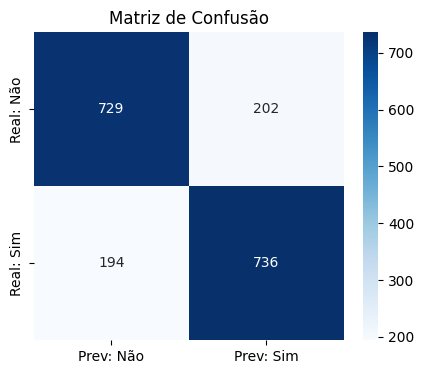

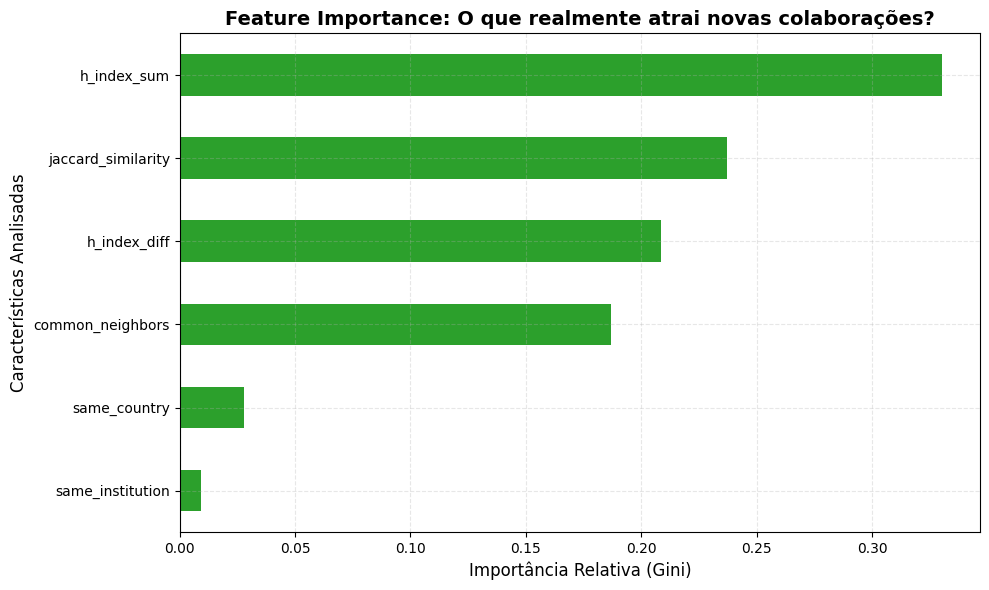

In [ ]:
# 2. Plotar a Matriz de Confusão (para ver falsos positivos/negativos)
plt.figure(figsize=(5, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Prev: Não", "Prev: Sim"],
    yticklabels=["Real: Não", "Real: Sim"],
)
plt.title("Matriz de Confusão")
plt.show()

plt.figure(figsize=(10, 6))
importances.plot.barh(color="#2ca02c")
plt.title(
    "Feature Importance: O que realmente atrai novas colaborações?",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Importância Relativa (Gini)", fontsize=12)
plt.ylabel("Características Analisadas", fontsize=12)
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

In [11]:
print("\n=== PERFIL MÉDIO DOS PARES ===")
# Junta o X_test com a resposta real y_test
analise_df = X_test.copy()
analise_df['Colaborou'] = y_test

# Calcula a média das características para o grupo 0 e o grupo 1
perfis = analise_df.groupby('Colaborou').mean()
display(perfis)


=== PERFIL MÉDIO DOS PARES ===


,same_country,same_institution,h_index_sum,h_index_diff,common_neighbors,jaccard_similarity
Colaborou,,,,,,
0,0.095596,0.002148,35.882922,19.423201,0.024705,0.000648
1,0.247312,0.043011,57.650538,21.710753,2.367742,0.039141
